In [2]:
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms

n_cpus = 4
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
NBINS = 8

### Load data

['ant_temp', 'freq', 'lst']


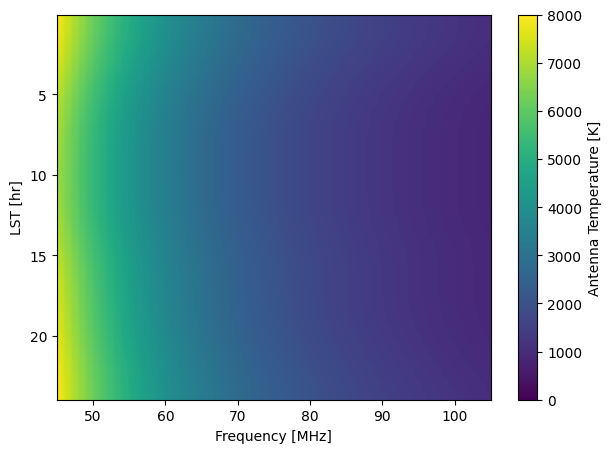

In [4]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

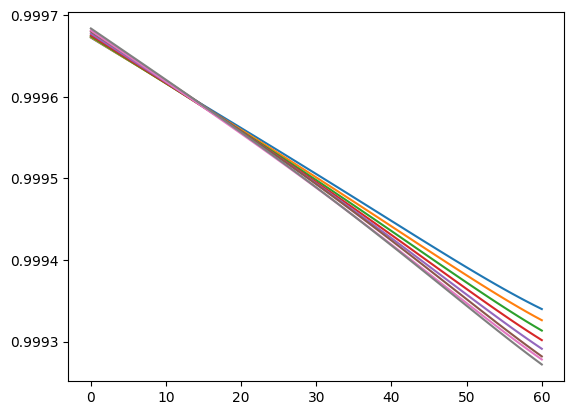

In [5]:
fg_bin = temp[:-(nspec%NBINS)].reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [6]:
tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = fg_mean[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(fg_bin, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

### Global signal

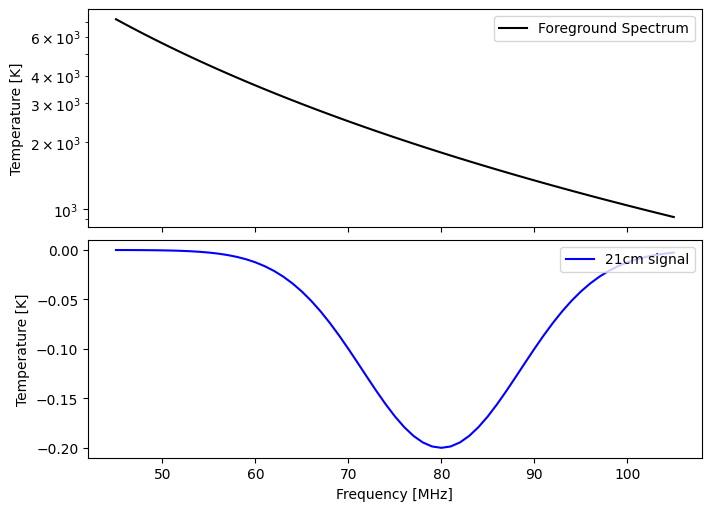

In [7]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

In [8]:
NFG = [5, 5, 4, 5, 4, 5, 4, 5]
lst_bins = [ms.lstbin.LSTBin(freq, fg_bin[i]+noise[i], np.diag(sigma_inv[i]), TRUE_T21, NFG[i]) for i in range(NBINS)]

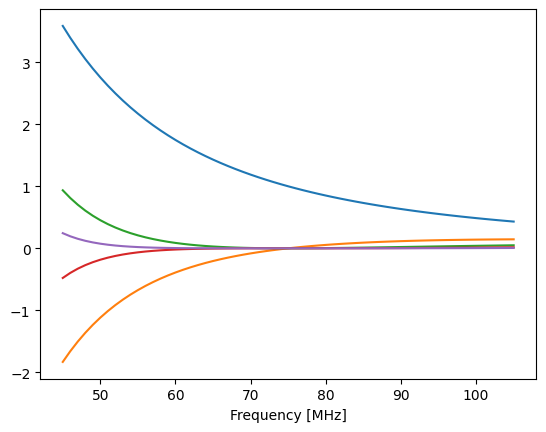

In [9]:
A = lst_bins[0].A

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Initialize and run sampler

In [10]:
nparticles = 1000
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins)

Iter: 21it [01:36,  4.68s/it, beta=0.00642, calls=53000, ESS=0.95, logZ=-9.31, accept=0.268, N=2, scale=0.994, corr=0.704] /home/christian/Documents/research/MIST/mistsim/.venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 48it [04:45,  5.95s/it, beta=1, calls=109000, ESS=0.966, logZ=-287, accept=0.244, N=2, scale=1.14, corr=0.71]       


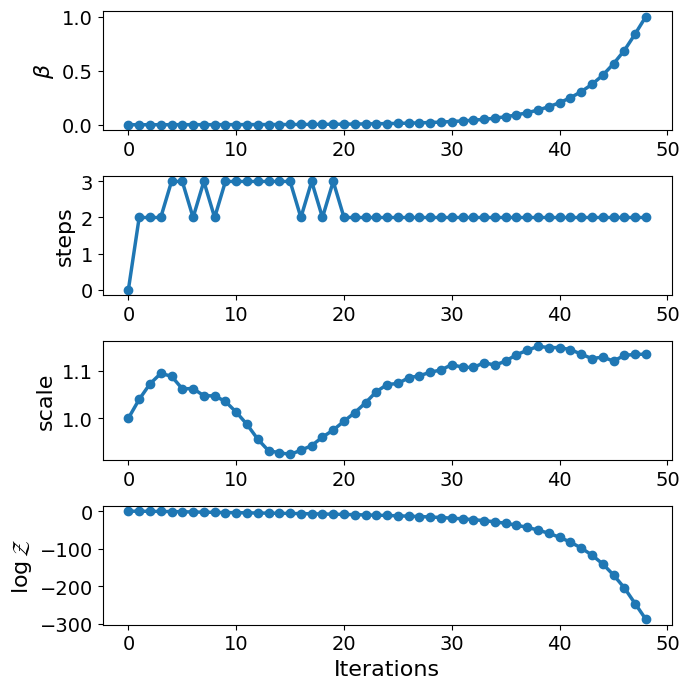

In [11]:
_ = pc.plotting.run(results, width=7, height=7)

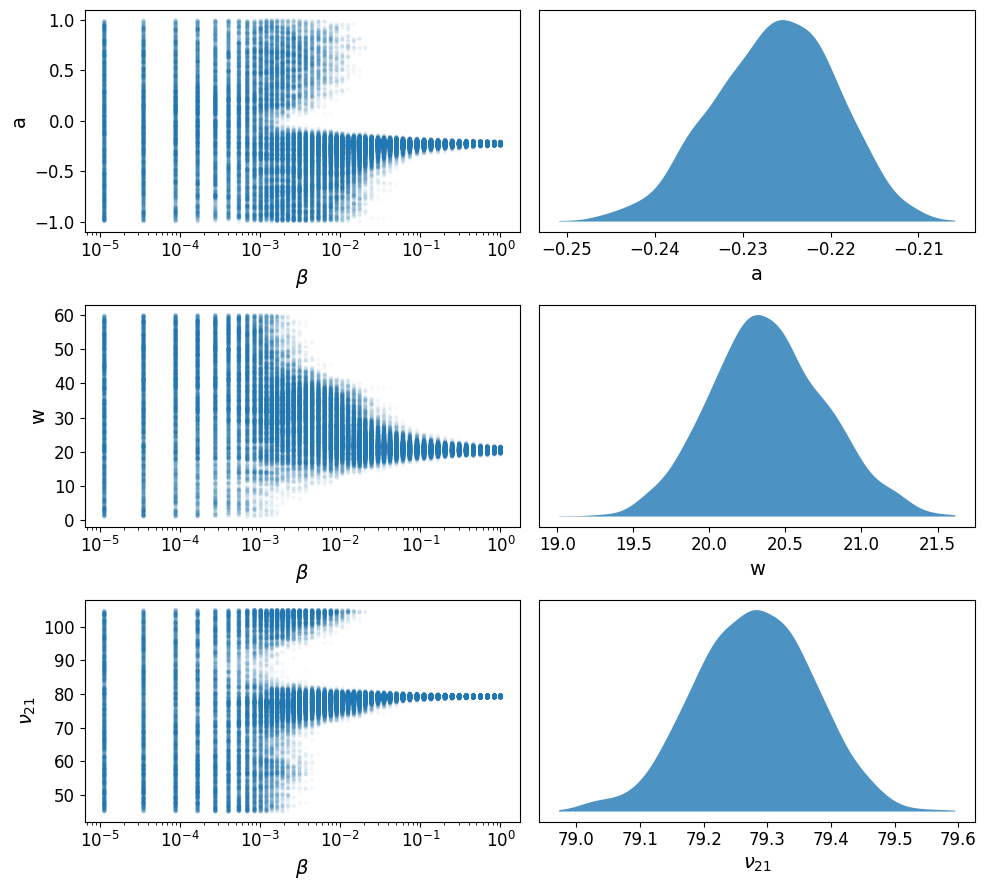

In [12]:
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)

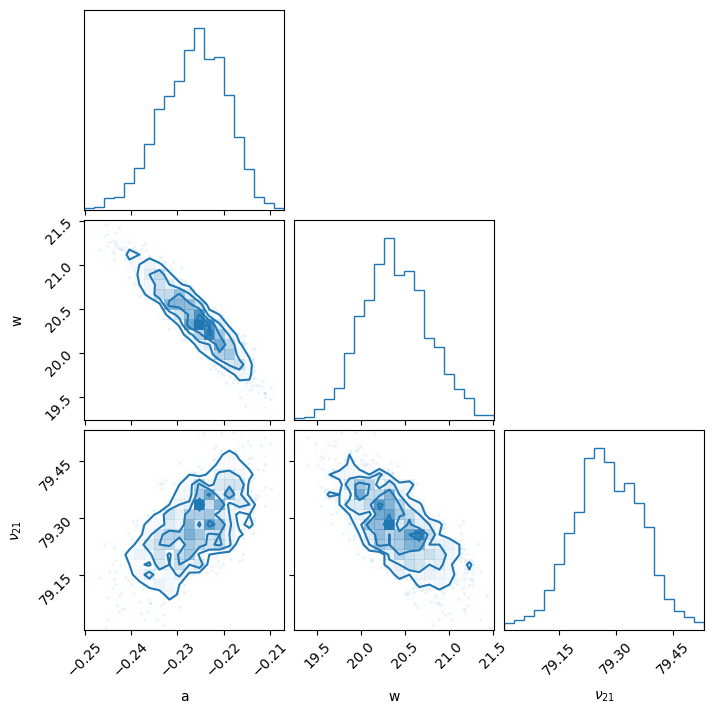

In [13]:
_ = pc.plotting.corner(results, labels=labels)#, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [14]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.22631776 20.389858   79.2787    ]
Standard deviation values =  [0.00693778 0.3699661  0.09066802]

[11.62867772  1.91202038  0.90982597]
[3.79339839 1.05376751 7.95537673]


In [16]:
np.savez(
    "results_120723.npz",
    results=results,
    true_params=TRUE_PARAMS,
    nfg=NFG,
    noise=noise,
    noise_cov_inv=sigma_inv,
)